# Esercitazione 2

## 1 Calcolo Monte Carlo di un integrale

### 1.1 Obiettivo

L'obiettivo di questo esercizio è la stima, con il metodo Monte Carlo, del seguente integrale
$$
I = \int_0^1 \frac{\pi}{2}\cos(\pi x/2) dx = 1
$$

### 1.2 Metodo


Suppongo sia $f(x)$ la funzione da integrare e $\Omega$ l'intervallo di integrazione. 

Vengono eseguiti N step Monte Carlo. Un singolo step consiste nell'estrazione di un numero casuale estratto con distribuzione di probabilità p(x) in $\Omega$ e nel calcolo di $f(x)/p(x)$. Dopo gli N step è quindi possibile calcolare una stima del valore aspettato di $f(x)/p(x)$. Questo fornisce una stima dell'integrale I.
Infatti
$$
    \langle \frac{f(x)}{p(x)} \rangle = \int_\Omega \frac{f(x)}{p(x)} p(x) \text{d} x = \int_\Omega f(x)
$$

Inoltre, immaginando di poter scegliere $p(x)$ a piacere, si può dimostrare che la scelta di $p(x) = f(x)$ è quella che riduce al minimo la varianza dell'integrale calcolato con questo metodo. $p(x)$ deve però essere normalizzata ed è quindi necessario saperla integrare. La tecnica dell'importance sampling consiste nel scegliere una $p(x)$ più simile possibile alla $f(x)$ che si desidera integrare.

### 1.3 Implementazione

Il codice realizzato implementa il metodo spiegato al paragrafo precedente utilizzando l'algoritmo della media a blocchi per stimare l'incertezza statistica sul valore dell'integrale calcolato.

Lo stesso programma può, a seconda di come viene eseguito, utilizzare una $p(x)$ uniforme oppure implementare la tecnica dell'importance sampling utilizzando $p(x) = 2(1-x)$. Questa distribuzione di probabilità è stata scelta osservando la funzione che deve essere integrata.


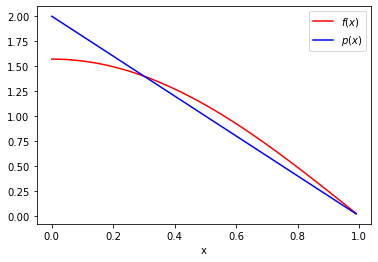

In [1]:
from IPython.display import display, Latex
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(0,1,0.01)
cos = np.pi*np.cos(np.pi*x/2)/2
y = 2*(1-x)
plt.plot(x, cos, color='red', label="$f(x)$")
plt.plot(x, y, color='blue', label="$p(x)$")
plt.xlabel("x")
plt.legend()
plt.show()

Si può osservare che la $p(x)$ segue l'andamento dell'integranda $f(x)$. Mi aspetto di ottenere una incertezza più bassa rispetto al campionamento uniforme

### 1.4 Utilizzo

Diversi parametri della simulazione possono essere impostati modificando la definizione delle rispettive costanti presenti nel codice. Il programma compilato richiede, per essere eseguito, due argomenti. Il primo permette di scegliere tra uniform sampling e importance sampling, il secondo deve invece essere utilizzato per specificare il file di output in cui salvare i risultati ottenuti.

### 1.5 Risultati

La prima stima dell'integrale è stata effettuata con campionamento uniforme. Sono stati utilizzati $10^6$ step Monte Carlo divisi in 100 blocchi. Il risultato ottenuto è il seguente:

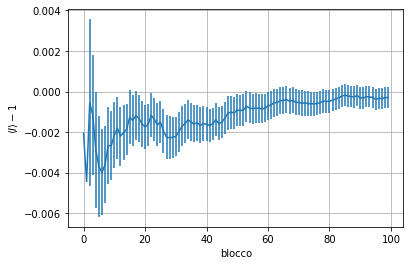

stima finale di I: 0.9997
incertezza: 0.0005

distante 0.6σ dal valore aspettato


In [2]:
i, err = np.loadtxt('../02/02.1/unif', usecols=(0,1), delimiter=" ", unpack=True)
x = np.arange(0, len(i))
plt.errorbar(x, i-1, err)
plt.xlabel("blocco")
plt.ylabel('$\\langle I \\rangle  - 1 $')
plt.grid()
plt.show()

print("stima finale di I: {:.4}".format(i[-1]))
print("incertezza: {:.1}".format(err[-1]))
print('\ndistante {:.1}σ dal valore aspettato'.format(abs(i[-1]-1)/err[-1]))

Il grafico mostra il progressivo miglioramento della stima dell'integrale all'aumentare del numero di blocchi considerati. Il risultato ottenuto risulta compatibile con il valore calcolato analiticamente.

Secondariamente ho invece utilizzato il metodo dell'importance sampling sfruttando la distribuzione di probabilità citata in precedenza. Ho utilizzato lo stesso numero di step Monte Carlo e di blocchi del campionamento uniforme. I risultati ottenuti sono rappresentati nel grafico seguente: 

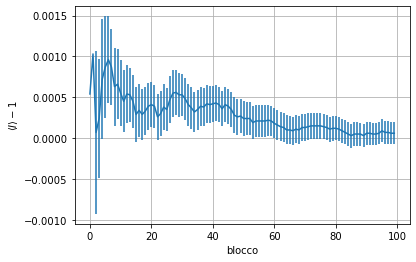

stima finale di I: 1.00006
incertezza: 0.00013

distante 0.4σ dal valore aspettato


In [3]:
i, err = np.loadtxt('../02/02.1/imp', usecols=(0,1), delimiter=" ", unpack=True)
x = np.arange(0, len(i))
plt.errorbar(x, i-1, err)
plt.xlabel("blocco")
plt.ylabel('$\\langle I \\rangle  - 1 $')
plt.grid()
plt.show()

print("stima finale di I: {:.6}".format(i[-1]))
print("incertezza: {:.2}".format(err[-1]))
print('\ndistante {:.1}σ dal valore aspettato'.format(abs(i[-1]-1)/err[-1]))

Si può osservare come l'incertezza ottenuta con l'importance sampling sia effettivamente minore di quella ottenuta con il campionamento uniforme. Il miglioramento è necessariamente dovuto al diverso metodo in quanto tutti gli altri parametri della simulazione sono stati mantenuti invariati.

## 2 Random Walks

### 2.1 Obiettivo

In questo esercizio viene simulato il random walk di una particella su un reticolo di passo fissato e nel continuo. L'obiettivo è la determinazione di 
 $$\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$$
 in funzione del numero di passi effettuati. $\vec{r}_N$ rappresenta la posizione della particella al passo N-esimo. Il valor medio si intende calcolato mediando su un gran numero di simulazioni di random walk.
 
Il risultato viene poi interpolato con la seguente funzione
$$\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}} = k\sqrt{N}$$
determinando il parametro $k$. Si studia quindi se il processo simulato è un processo diffusivo.

### 2.2 Implementazione

Per risolvere questo esercizio ho realizzato le seguenti classi:
* `Walker` - classe virtuale che definisce le variabili e le funzioni che deve avere una classe che implementi un random walk. Tra queste vi sono sia la funzione che permette di effettuare un passo sia funzioni che restituiscono informazioni sulla posizione del walker.
* `WalkerLattice` - classe derivata da `Walker` che implementa il random walk su un reticolo. Il costruttore di questa classe permette di impostare il passo del reticolo
* `WalkerContinuum` - classe derivata da `Walker` che implementa il random walk nel continuo. Il costruttore di questa classe permette di impostare la lunghezza dei passi.

l'intero codice è stato realizzato in modo tale da funzionare in un numero arbitrario di dimensioni `n_dims`. Tutte le simulazioni sono poi state eseguite in 3 dimensioni.

Il walk sul reticolo è stato implementato nel seguente modo:
inizialmente il walker si trova nel punto (0,0,0), quando viene chiamata la funzione walk() vengono estratti casualmente e con distribuzione uniforme la direzione e il verso in cui deve avvenire il movimento. La direzione può in questo caso assumere solo i valori discreti da 0 a `n_dims`. Il passo avviene poi nella direzione e verso estratti con un passo della lunghezza del passo del reticolo.

Il walk nel continuo è stato invece implementato nel seguente modo:
inizialmente il walker si trova nel punto (0,0,0), quando viene chiamata la funzione walk() viene estratta casualmente la direzione in cui deve avvenire il movimento. Per far questo vengono estratti i due angoli $\theta$ e $\phi$ che permettono di determinare la posizione da raggiungere utilizzando coordinate sferiche centrate nella posizione corrente del walker. Il raggio è invece pari alla lunghezza del passo, che è fissato.
Per ottenere una estrazione della direzione con distribuzione di probabilità uniforme sulla sfera, l'angolo $\phi$ deve essere campionato uniformemente (tra $0$ e $2\pi$) mentre l'angolo azimuthale $\theta$ deve essere estratto con distribuzione di probabilità $\frac{\text{d}p}{\text{d}\theta} = 0.5\cdot\sin(\theta)$ di modo che $\frac{\text{d}p}{\text{d}\Omega} = \frac{1}{4\pi}$. La funzione che campiona questa distribuzione di probabilità è stata realizzata utilizzando il metodo dell'inversione della funzione cumulativa.

Il calcolo di $\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$ viene effettuato utilizzando l'algoritmo della media a blocchi. Per ciascun blocco vengono eseguiti M/K simulazioni di random walk. Durante ogni simulazione, ad ogni passo viene sommata la distanza dall'origine del walker in una opportuna variabile che permette di accumularne i valori ottenuti da ciascun walk per poi calcolarne il valor medio. Questi valori medi sono quindi trattati nel modo classico previsto dall'algoritmo della media a blocchi.

### 2.3 Utilizzo

I parametri che determinano il numero di walk da eseguire, il numero di blocchi, il numero di passi di un singolo walk e il numero di dimensioni dello spazio sono definiti da delle costanti. È possibile modificarle e ricompilare il programma nel caso si desideri eseguire simulazioni con parametri differenti.

Il programma deve essere eseguito con due argomenti che specifichino la tipologia di random walk che si vuole simulare e il file nel quale salvare i risultati ottenuti.

Il file di output contiene solamente i valori finali di $\langle |\vec{r}_i|^2 \rangle_{RW}$ ottenuti considerando tutti i blocchi eseguiti.
Ciascuna riga contiene, nel seguente ordine:
- `i` 
- valor medio, sulle varie simulazioni di random walk, della distanza dall'origine dopo `i` steps ($\langle |\vec{r}_i|^2 \rangle_{RW}$ )
- incertezza statistica sul valore precedente

### 2.4 Risultati

Per entrambe le simulazioni, su reticolo e nel continuo, ho eseguito $10^6$ random walk da 100 passi ciascuno e divisi in 100 blocchi. Sia il passo del reticolo sia la lunghezza del passo del walker nel continuo sono stati presi uguali a 1 (in unità di codice). I risultati ottenuti, nei due casi, sono i seguenti:

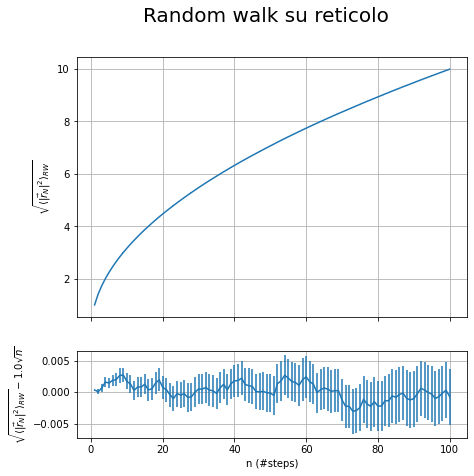

In [5]:
from scipy.optimize import curve_fit
def f(x, k):
    return k*np.sqrt(x);

x, r2, err = np.loadtxt('../02/02.2/latt', usecols=(0,1,2), delimiter=" ", unpack=True)
fig, (p1, p2) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
p1.errorbar(x, np.sqrt(r2), err/(2*np.sqrt(r2)) )
p1.set( ylabel='$\\sqrt{\\langle |\\vec{r}_N|^2 \\rangle_{RW}}$')
p1.grid()
fig.set_size_inches(7, 7)
fig.suptitle('Random walk su reticolo', size=20)
#fit dei dati con una funzione f = k sqrt(n)
p_v, p_cov = curve_fit(f, x, np.sqrt(r2))

p2.errorbar(x, np.sqrt(r2)-p_v[0]*np.sqrt(x), err/(2*np.sqrt(r2)))
p2.set(xlabel='n (#steps)', 
       ylabel = '$\\sqrt{\\langle |\\vec{r}_N|^2 \\rangle_{RW}}-$'+ str(round(p_v[0], 2)) + '$\\sqrt{n}$')
p2.grid()

plt.show()


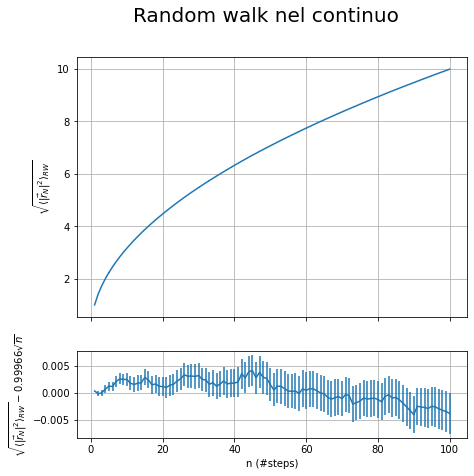

In [7]:
x, r2, err = np.loadtxt('../02/02.2/contt', usecols=(0,1,2), delimiter=" ", unpack=True)
fig, (p1, p2) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
p1.errorbar(x, np.sqrt(r2), err/(2*np.sqrt(r2)) )
p1.set( ylabel='$\\sqrt{\\langle |\\vec{r}_N|^2 \\rangle_{RW}}$')
p1.grid()
fig.suptitle('Random walk nel continuo', size=20)
p_v, p_cov = curve_fit(f, x, np.sqrt(r2))

p2.errorbar(x, np.sqrt(r2)-p_v[0]*(x**0.5), err/(2*np.sqrt(r2)))
p2.set(xlabel='n (#steps)', 
       ylabel = '$\\sqrt{\\langle |\\vec{r}_N|^2 \\rangle_{RW}}-$'+ str(round(p_v[0], 5)) + '$\sqrt{n}$')

p2.grid()

fig.set_size_inches(7, 7)
plt.show()


I grafici mostrano la distanza media percorsa dal walker in funzione del numero di passi. I risultati di entrambe le simulazioni sono stati interpolati con la funzione $f(n) = k\sqrt{n}$ con il parametro k da determinare. Il grafico inferiore, in entrambe le immagini, mostra la distanza dei dati sperimentali dalla funzione interpolata permettendo inoltre di apprezzare le incertezze statistiche calcolate. Le incertezze salvate nei file di output sono relative alle distanze al quadrato, sono state quindi propagate al valore di $\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$ tramite la relazione
$$
    \sigma_r = \sigma_{r^2}/2r
$$
In entrambi i casi i valori di $k$ ottenuti con l'interpolazione sono compatibili con 1, in accordo con un comportamento diffusivo.